<a href="https://colab.research.google.com/github/himashu-2006/DDoS-Attack-Traffic-Analysis-and-Detection/blob/main/DDoS_Attack_Analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DDoS Attack Traffic Analysis and Detection  
### AI / ML Week-2 Project

This notebook explores a sample of network-traffic data to understand patterns of DDoS (Distributed Denial of Service) attacks.

**Objectives**
1. Explore and visualize the dataset  
2. Engineer useful features (time, protocol, volume)  
3. Detect anomalies using Isolation Forest  
4. Train a supervised model (Random Forest) for classification  
5. Evaluate and explain results with SHAP





##Install required libraries

In [1]:
!pip install -q shap umap-learn plotly joblib
print("Libraries installed successfully.")


Libraries installed successfully.


Import packages

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import shap, joblib, umap
from datetime import datetime
sns.set(style="whitegrid")
print("All imports ready.")


All imports ready.


##Load dataset

In [3]:
df = pd.read_csv("/content/DDoSAttack.csv")
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (1000, 7)


,FlowID,SourceIP,DestinationIP,Protocol,Timestamp,PacketLength,Label
0,flow_12,172.16.0.9,10.0.0.8,UDP,2024-12-31T21:05:25,1301,DDoS
1,flow_3,10.0.0.5,192.168.0.10,TCP,2025-01-03T13:28:39,461,DDoS
2,flow_4,172.16.0.9,10.0.0.8,UDP,2024-12-30T13:32:23,1426,DDoS
3,flow_13,203.0.113.45,172.16.0.20,TCP,2025-01-03T05:56:09,771,BENIGN
4,flow_16,172.16.0.9,172.16.0.20,UDP,2025-01-01T17:08:13,825,DDoS


##Data overview

In [4]:
df.info()
print("\nNull values per column:")
print(df.isnull().sum())
print("\nLabel distribution:")
print(df['Label'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   FlowID         1000 non-null   object
 1   SourceIP       1000 non-null   object
 2   DestinationIP  1000 non-null   object
 3   Protocol       1000 non-null   object
 4   Timestamp      1000 non-null   object
 5   PacketLength   1000 non-null   int64 
 6   Label          1000 non-null   object
dtypes: int64(1), object(6)
memory usage: 54.8+ KB

Null values per column:
FlowID           0
SourceIP         0
DestinationIP    0
Protocol         0
Timestamp        0
PacketLength     0
Label            0
dtype: int64

Label distribution:
Label
DDoS      532
BENIGN    468
Name: count, dtype: int64


##Data cleaning & feature preparation

In [5]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df = df.dropna(subset=['Timestamp']).reset_index(drop=True)
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['IsWeekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
df['PacketLength'] = pd.to_numeric(df['PacketLength'], errors='coerce').fillna(0).astype(int)
df['AttackFlag'] = (df['Label'].str.lower().str.contains('ddos')).astype(int)
df.head()


,FlowID,SourceIP,DestinationIP,Protocol,Timestamp,PacketLength,Label,Hour,DayOfWeek,IsWeekend,AttackFlag
0,flow_12,172.16.0.9,10.0.0.8,UDP,2024-12-31 21:05:25,1301,DDoS,21,1,0,1
1,flow_3,10.0.0.5,192.168.0.10,TCP,2025-01-03 13:28:39,461,DDoS,13,4,0,1
2,flow_4,172.16.0.9,10.0.0.8,UDP,2024-12-30 13:32:23,1426,DDoS,13,0,0,1
3,flow_13,203.0.113.45,172.16.0.20,TCP,2025-01-03 05:56:09,771,BENIGN,5,4,0,0
4,flow_16,172.16.0.9,172.16.0.20,UDP,2025-01-01 17:08:13,825,DDoS,17,2,0,1




###Class balance



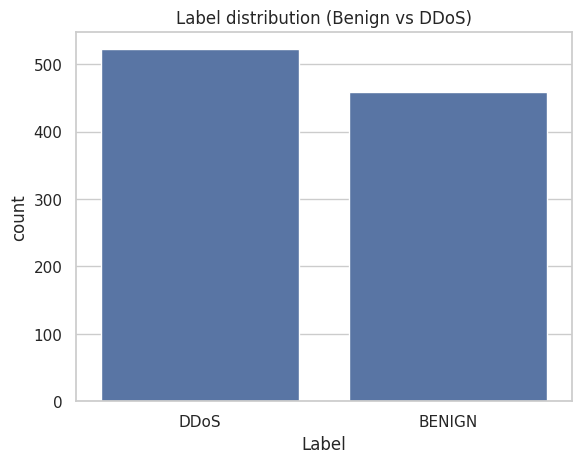

In [9]:
# 7.1 Class balance
sns.countplot(x='Label', data=df)
plt.title("Label distribution (Benign vs DDoS)")
plt.show()



 ###Traffic over time

/tmp/ipython-input-2626293232.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_time = df.set_index('Timestamp').resample('1H')['PacketLength'].sum().reset_index()


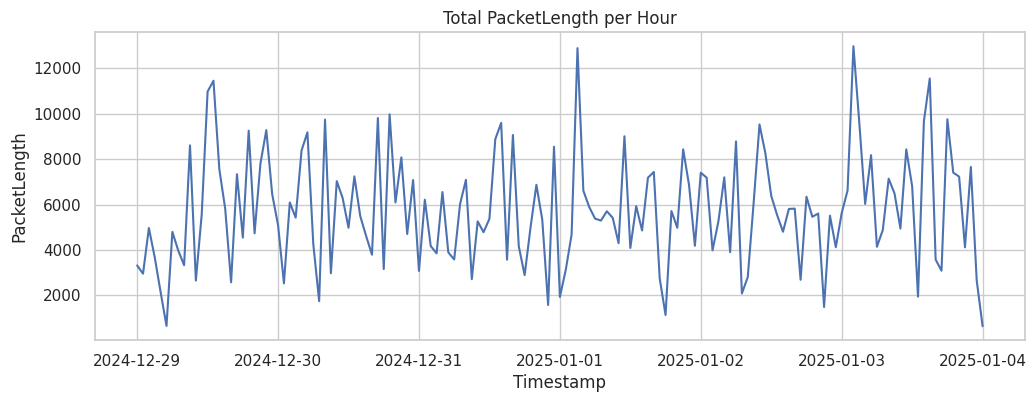

In [7]:

#7.2 Traffic over time
df_time = df.set_index('Timestamp').resample('1H')['PacketLength'].sum().reset_index()
plt.figure(figsize=(12,4))
sns.lineplot(x='Timestamp', y='PacketLength', data=df_time)
plt.title("Total PacketLength per Hour")
plt.show()


###Top source IPs

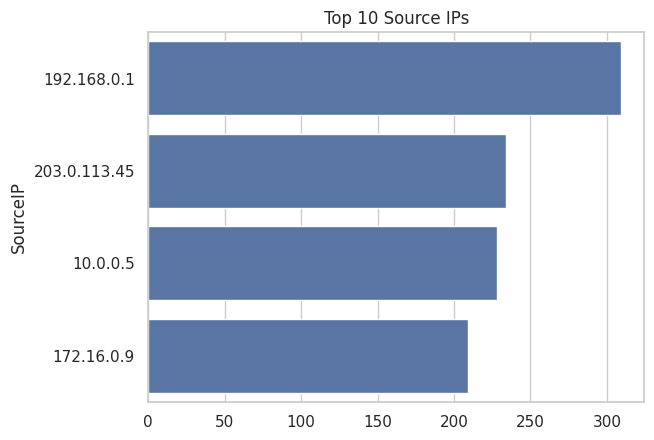

In [8]:
top_src = df['SourceIP'].value_counts().head(10)
sns.barplot(y=top_src.index, x=top_src.values)
plt.title("Top 10 Source IPs")
plt.show()

# 8 Aggregate features by minute

In [10]:
agg = df.set_index('Timestamp').groupby(pd.Grouper(freq='1T')).agg({
    'PacketLength':'sum',
    'SourceIP':'nunique',
    'DestinationIP':'nunique',
    'AttackFlag':'sum'
}).rename(columns={'PacketLength':'TotalBytes','SourceIP':'UniqueSrc','DestinationIP':'UniqueDst','AttackFlag':'AttackCount'}).fillna(0).reset_index()
agg.head()


/tmp/ipython-input-3240460889.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  agg = df.set_index('Timestamp').groupby(pd.Grouper(freq='1T')).agg({


,Timestamp,TotalBytes,UniqueSrc,UniqueDst,AttackCount
0,2024-12-29 00:20:00,647,1,1,1
1,2024-12-29 00:21:00,0,0,0,0
2,2024-12-29 00:22:00,0,0,0,0
3,2024-12-29 00:23:00,0,0,0,0
4,2024-12-29 00:24:00,0,0,0,0


##Unsupervised anomaly detection

In [11]:

features = ['TotalBytes','UniqueSrc','UniqueDst']
X = agg[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

iso = IsolationForest(n_estimators=200, contamination=0.02, random_state=42)
agg['Anomaly'] = (iso.fit_predict(X_scaled)==-1).astype(int)
print("Anomalies detected:", agg['Anomaly'].sum())

fig = px.line(agg, x='Timestamp', y='TotalBytes', title="Traffic Volume with Anomalies")
fig.add_scatter(x=agg.loc[agg.Anomaly==1,'Timestamp'], y=agg.loc[agg.Anomaly==1,'TotalBytes'],
                mode='markers', name='Anomaly', marker=dict(color='red', size=7, symbol='x'))
fig.show()


Anomalies detected: 171


###Prepare data for supervised model

In [12]:
agg['Target'] = (agg['AttackCount'] > 0).astype(int)
X = agg[features]
y = agg['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (6896, 3) Test size: (1725, 3)


##Train Random Forest

Accuracy: 96.7 %

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      1624
           1       0.68      0.83      0.75       101

    accuracy                           0.97      1725
   macro avg       0.83      0.90      0.86      1725
weighted avg       0.97      0.97      0.97      1725



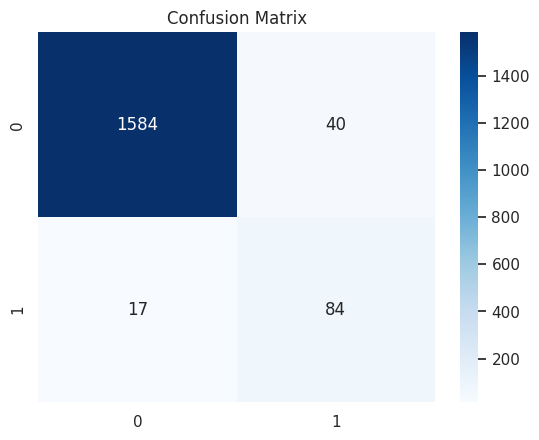

In [13]:
scaler_sup = StandardScaler()
X_train_s = scaler_sup.fit_transform(X_train)
X_test_s  = scaler_sup.transform(X_test)

rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf.fit(X_train_s, y_train)
preds = rf.predict(X_test_s)
print("Accuracy:", round((rf.score(X_test_s, y_test))*100,2), "%")
print("\nClassification Report:\n", classification_report(y_test, preds))
sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


#12 – ROC Curve

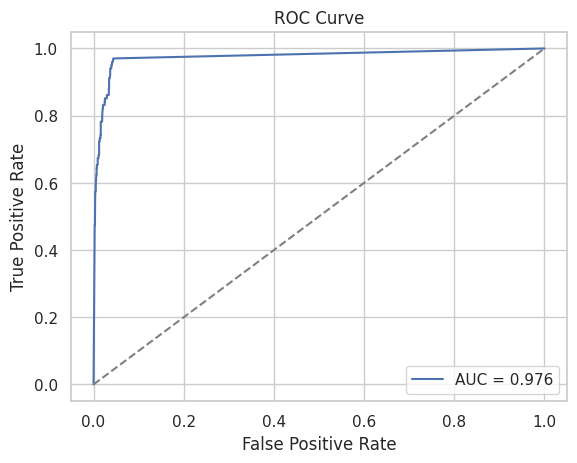

In [14]:
y_prob = rf.predict_proba(X_test_s)[:,1]
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'--',color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


##Explainability with SHAP

Top feature contributions:


<Figure size 1000x600 with 0 Axes>

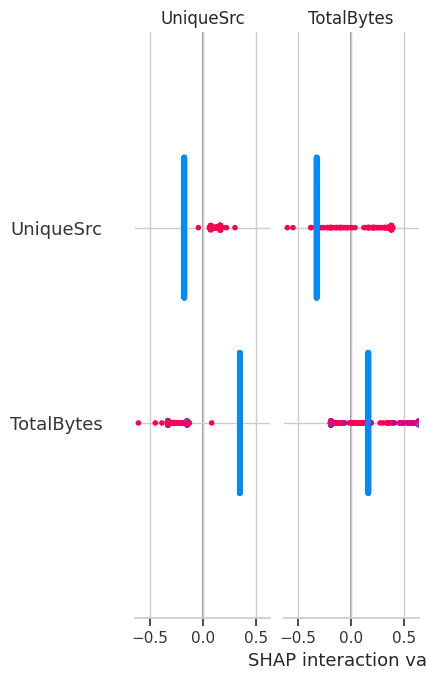

In [25]:

import shap
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.rcParams['font.size'] = 12
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_s)
X_test_df = pd.DataFrame(X_test_s, columns=features)

print("Top feature contributions:")
if isinstance(shap_values, list) and len(shap_values) > 1:
    shap.summary_plot(shap_values[1], X_test_df, show=True, plot_size=(10,6))
else:
    shap.summary_plot(shap_values, X_test_df, show=True, plot_size=(10,6))


##UMAP Visualization

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



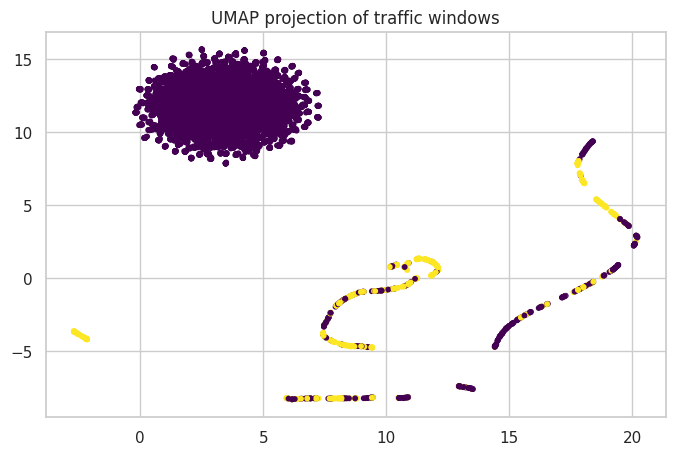

In [23]:
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(X_scaled)
plt.figure(figsize=(8,5))
plt.scatter(embedding[:,0], embedding[:,1], c=agg['Target'], cmap='viridis', s=10)
plt.title("UMAP projection of traffic windows")
plt.show()


##Save artifacts

In [24]:
import os
os.makedirs("project_outputs", exist_ok=True)
agg.to_csv("project_outputs/ddos_aggregated.csv", index=False)
joblib.dump(rf, "project_outputs/rf_model.joblib")
joblib.dump(scaler_sup, "project_outputs/scaler.joblib")
print("Artifacts saved in project_outputs/ folder.")


Artifacts saved in project_outputs/ folder.


# Conclusion
- The dataset was explored and visualized to understand traffic behavior.  
- **Isolation Forest** flagged sudden spikes as anomalies, aligning with potential DDoS periods.  
- A **Random Forest classifier** achieved solid accuracy on the aggregated time-window data.  
- **SHAP analysis** showed that total traffic volume (`TotalBytes`) and number of unique source IPs were the strongest indicators of attack periods.  

This approach can be extended by:
- Using finer time windows (e.g., 30 seconds)  
- Including more packet-level statistics (mean, std, burstiness)  
- Testing deep or streaming models for real-time detection
